In [ ]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch import optim
# from torch.optim.lr_scheduler import ReduceLR
from tqdm import tqdm
import pickle
# from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from sklearn.model_selection import train_test_split
from PIL import Image
from itertools import chain

In [ ]:
# To mount drive:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Checking GPU:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!cp "/content/drive/MyDrive/CS5100 Project/resized_images_v4_224.zip" -r "/content/resized_images_v4_224.zip"
!unzip /content/resized_images_v4_224.zip -d /content/resized_images_v4_224

Streaming output truncated to the last 5000 lines.
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_014.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_015.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_016.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_017.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_018.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_019.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028897_020.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028898_000.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028899_000.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028899_001.png  
  inflating: /content/resized_images_v4_224/resized_images_v4_224/00028899_002.png  
  inflating: /

In [ ]:
def read_pickle_file(filepath):
  with open(filepath, "rb") as f:
    return pickle.load(f)

In [ ]:
# Function to Load Trained Models:

def loadModel(model_name, model):
  state_dict = torch.load("/content/drive/MyDrive/CS5100 Project/Pretrained Models/version3/" + model_name + ".pt")
  model.load_state_dict(state_dict)
  return model

In [ ]:
class ChestXRay_ImageDataset(Dataset):

    def __init__(self, metadata, transforms):
        self.metadata = metadata
        self.transforms = transforms

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image_path = self.metadata["image_path"][index]
        # hurricane_image = io.imread(image_path)
        xray_image = Image.open(image_path).convert("RGB")
        # label = self.metadata["Disease_Labels"][index]
        label = self.metadata["disease_vec"][index].astype(int)


        if self.transforms:
            xray_image = self.transforms(xray_image)

        return xray_image, label

In [ ]:
def display_sample_images(dataloader, batch_size, sample_size, num_rows, class_dict):

  def get_labels_for_one_hot(labels, class_dict):
    # images, labels = next(iter(testloader))
    # for l in labels:
    label_set = []
    for i, val in enumerate(labels):
      if int(val) == 1:
        label = class_dict[i]
        label_set.append(label)
      # print(label_set)
    label_title = ", ".join(label_set)
    return label_title


  sample_size = min(sample_size, batch_size)
  images, labels = next(iter(dataloader))
  images = images.numpy()

  fig = plt.figure(figsize = (30, 10))
  for i in np.arange(sample_size):
      ax = fig.add_subplot(num_rows, sample_size/num_rows, i+1, xticks = [], yticks = [])
      ax.imshow(np.squeeze(np.transpose(images[i], (1, 2 ,0))))
      # ax.set_title(str(class_dict[labels[i].item()]))
      ax.set_title(str(get_labels_for_one_hot(labels[i], class_dict)))
  
  return

In [ ]:
# Write and Read Lists:
# Used to Save Train and Test Losses for all Epochs

def write_lists(list_, fname, to_pickle):
  path ="/content/drive/MyDrive/CS5100 Project/Loss Files/version3/"
  if to_pickle:
    with open(path + fname, "wb+") as f:
      pickle.dump(list_, fname)
  else:
    with open(path + fname, 'w') as f:
        for s in list_:
            f.write(str(s) + '\n')


def read_lists(fname, pickle):
  path = "/content/drive/MyDrive/CS5100 Project/Loss Files/version3/"
  if to_pickle:
    with open(path + fname, "rb") as f:
      list_ = pickle.load(f)
  else: 
    with open(path + fname, 'r') as f:
        list_ = [float(line.rstrip('\n')) for line in f]
  return list_


In [ ]:
# Training and Validating Model on Data:

def train(epoch, model, trainloader, validloader, criterion, optimizer, scheduler, model_name, valid_loss_min = np.Inf):
  # Training the model:
  start = time.time()
  
  train_losses, validation_losses = [], []
  for e in range(epochs):
    model.train()
    train_loss, validation_loss = 0.0, 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        # print("OUTPUT")
        # print("==============================")
        # print(output, type(output))
        # print(output[0], type(output[0]))
        # print("LABELS")
        # print("==============================")
        # print(labels, type(labels))
        # print(labels[0], type(labels[0]))
        # print("CRITERION")
        # print("==============================")
        # print(criterion(output, labels))
        loss = criterion(output, labels.float())
        # print(type(loss))
        # print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    # Validate the Model:
    model.eval()
    for images, labels in validloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels.float())
      validation_loss += loss.item()*images.size(0)
    
    if scheduler is not None:
      scheduler.step(validation_loss)

    train_loss = train_loss/len(trainloader.dataset)
    validation_loss = validation_loss/len(validloader.dataset)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    write_lists(train_losses, "intermediate_train_losses_" + model_name, to_pickle=False)
    write_lists(validation_losses, "intermediate_validation_losses_" + model_name, to_pickle=False) 

    print("Epoch: {}/{}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(e+1, epochs, train_loss, validation_loss))
    
    if validation_loss <= valid_loss_min:
      print("Decrease in Validation Loss: {:.5f} to {:.5f}. Saving Model...".format(valid_loss_min, validation_loss))
      # torch.save(model.state_dict(), "/content/" + model_name + ".pt")
      torch.save(model.state_dict(), "/content/drive/MyDrive/CS5100 Project/Pretrained Models/version3/" + model_name + ".pt")
      valid_loss_min = validation_loss

  write_lists(train_losses, "train_losses_" + model_name, to_pickle=False)
  write_lists(validation_losses, "validation_losses_" + model_name, to_pickle=False) 
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
  
  return train_losses, validation_losses


In [ ]:
from sklearn.metrics import roc_curve, auc

def evaluate_model(dataloader, criterion, model):
  test_loss = 0.0
  y_preds_list, y_list = [], []
  # images, labels = next(iter(testloader))
  criterion = nn.BCELoss()
  model.to(device)
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    loss = criterion(output, labels.float())
    test_loss += loss.item()*images.size(0)
    y_preds = np.asarray(output.data.cpu())
    y = np.asarray(labels.data.cpu())
    y_preds_list.append(y_preds)
    y_list.append(y)


  all_y_preds = np.concatenate(y_preds_list)
  all_y_truth = np.concatenate(y_list)

  test_loss = test_loss/all_y_preds.shape[0]

  return test_loss, all_y_preds, all_y_truth



def plot_roc_curve(class_dict, y_preds, y_truth, set_, get_auc=True):
  plt.figure(figsize=(12, 9))
  auc_dict = dict()
  for (idx, c_label) in enumerate(class_dict.values()):
      fpr, tpr, thresholds = roc_curve(y_truth[:,idx].astype(int), y_preds[:,idx])
      plt.plot(fpr, tpr, label="{}: [AUC: {:.03f}]".format(c_label, auc(fpr, tpr)))
      auc_dict[c_label] = auc(fpr, tpr)
  # plt.legend()
  plt.legend()
  plt.title("ROC Curve for the {} Set".format(set_))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # fig.savefig('trained_net.png')
  plt.show()
  return auc_dict

In [ ]:
filepath = "/content/class_dict_wo_NF.pkl"
class_dict = read_pickle_file(filepath)
class_dict

{0: 'Atelectasis',
 1: 'Cardiomegaly',
 2: 'Consolidation',
 3: 'Edema',
 4: 'Effusion',
 5: 'Emphysema',
 6: 'Fibrosis',
 7: 'Hernia',
 8: 'Infiltration',
 9: 'Mass',
 10: 'Nodule',
 11: 'Pleural_Thickening',
 12: 'Pneumonia',
 13: 'Pneumothorax'}

In [ ]:
df = pd.read_csv("/content/final_df_all_images_wo_NF_labels.csv")

In [ ]:
df.drop(columns=["disease_vec"], axis=1, inplace=True)
df['disease_vec'] = df.apply(lambda x: [x[class_dict.values()].values], 1).map(lambda x: x[0])
df["disease_vec"] = df["disease_vec"].apply(lambda x: np.array(x, dtype=int))
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,['Cardiomegaly'],0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,00000001_001.png,"['Cardiomegaly', 'Emphysema']",1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,00000001_002.png,"['Cardiomegaly', 'Effusion']",2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,00000002_000.png,['No Finding'],0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,00000003_000.png,['Hernia'],0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
all_labels = list(class_dict.values())
# all_labels
total_data = 0
for c_label in all_labels:
  print("{}: {}".format(c_label, df[c_label].sum()))
  total_data += df[c_label].sum()

print("\n")
print("Frequency of Labels: {}".format(total_data))
# print("Frequency of No Findings: {}".format(df.shape[0] - total_data))

Atelectasis: 11559
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2303
Effusion: 13317
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Pleural_Thickening: 3385
Pneumonia: 1431
Pneumothorax: 5302


Frequency of Labels: 81176


In [ ]:
df["image_path"] = "/content/resized_images_v4_224/resized_images_v4_224/" + df["Image Index"]

In [ ]:
print(len(df["Image Index"].unique()))

112120


In [ ]:
X_columns = df.columns.tolist()
X_columns.remove("disease_vec")
print(X_columns)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'image_path']


In [ ]:
X, y = df[X_columns], df["disease_vec"]

In [ ]:
print(X.shape, y.shape)

(112120, 27) (112120,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=101, shuffle=True)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(110998, 27) (110998,)
(1122, 27) (1122,)


In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1).reset_index().drop("index", axis=1)

rs = np.random.RandomState(101)
msk = rs.rand(len(train_df)) < 0.85
valid_df = train_df[~msk].reset_index().drop("index", axis=1)
train_df = train_df[msk].reset_index().drop("index", axis=1)


In [ ]:
print(train_df.shape, valid_df.shape, test_df.shape)

(94308, 28) (16690, 28) (1122, 28)


In [ ]:
transform = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(112),
        # transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5])
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
trainset = ChestXRay_ImageDataset(train_df, transform)
testset = ChestXRay_ImageDataset(test_df, transform)
validset = ChestXRay_ImageDataset(valid_df, transform)

trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=True)
validloader = DataLoader(validset, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

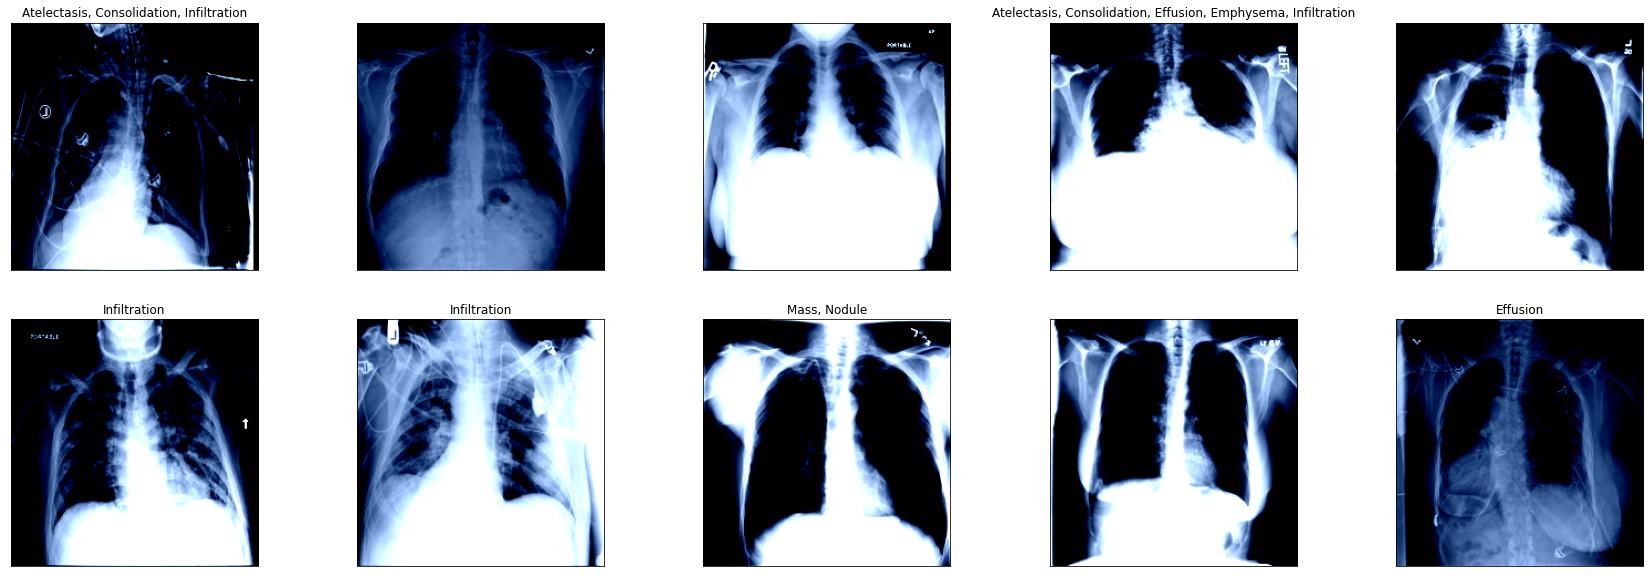

In [ ]:
batch_size = 16
sample_size = 10
num_rows = 2
display_sample_images(testloader, batch_size, sample_size, num_rows, class_dict)

# RESNET 152


In [ ]:
resnet152 = models.resnet152(pretrained = True)

for param in resnet152.parameters():
    param.requires_grad = False

num_in_feats = resnet152.fc.in_features
resnet152.fc = nn.Sequential(
            nn.Linear(num_in_feats, 14),
            nn.Sigmoid())
# densenet121.classifier

resnet152.to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
lr = 0.001
# optimizer = optim.SGD(densenet121.classifier.parameters(), lr=lr, momentum=0.9, weight_decay=0.1)
optimizer = optim.Adam(resnet152.fc.parameters(), lr=lr)
factor = 0.1
scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=2, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
epochs = 30
# model_name = "densenet161_adam_e50_bs128_lr00001_reqgrad_test1"
model_name = "resnet152_bce_e30_b16_lr0001_Adam_norm_sched_df_all_images_noNF_labels_random_split"
train_losses, validation_losses = train(epochs, resnet152, trainloader, validloader, criterion, optimizer, scheduler, model_name, valid_loss_min = np.Inf)

Epoch: 1/30, Train Loss: 0.18053, Validation Loss: 0.18553
Decrease in Validation Loss: inf to 0.18553. Saving Model...
Epoch: 2/30, Train Loss: 0.17772, Validation Loss: 0.18599
Epoch: 3/30, Train Loss: 0.17682, Validation Loss: 0.17561
Decrease in Validation Loss: 0.18553 to 0.17561. Saving Model...
Epoch: 4/30, Train Loss: 0.17617, Validation Loss: 0.17455
Decrease in Validation Loss: 0.17561 to 0.17455. Saving Model...
Epoch: 5/30, Train Loss: 0.17534, Validation Loss: 0.17219
Decrease in Validation Loss: 0.17455 to 0.17219. Saving Model...
Epoch: 6/30, Train Loss: 0.17431, Validation Loss: 0.17277
Epoch: 7/30, Train Loss: 0.17428, Validation Loss: 0.17470


In [ ]:
loss_test = """Epoch: 1/30, Train Loss: 0.18053, Validation Loss: 0.18553
Decrease in Validation Loss: inf to 0.18553. Saving Model...
Epoch: 2/30, Train Loss: 0.17772, Validation Loss: 0.18599
Epoch: 3/30, Train Loss: 0.17682, Validation Loss: 0.17561
Decrease in Validation Loss: 0.18553 to 0.17561. Saving Model...
Epoch: 4/30, Train Loss: 0.17617, Validation Loss: 0.17455
Decrease in Validation Loss: 0.17561 to 0.17455. Saving Model...
Epoch: 5/30, Train Loss: 0.17534, Validation Loss: 0.17219
Decrease in Validation Loss: 0.17455 to 0.17219. Saving Model...
Epoch: 6/30, Train Loss: 0.17431, Validation Loss: 0.17277
Epoch: 7/30, Train Loss: 0.17428, Validation Loss: 0.17470
Epoch: 1/30, Train Loss: 0.17491, Validation Loss: 0.17999
Decrease in Validation Loss: inf to 0.17999. Saving Model...
Epoch: 2/30, Train Loss: 0.17417, Validation Loss: 0.17657
Decrease in Validation Loss: 0.17999 to 0.17657. Saving Model...
Epoch: 3/30, Train Loss: 0.17420, Validation Loss: 0.17631
Decrease in Validation Loss: 0.17657 to 0.17631. Saving Model...
Epoch: 4/30, Train Loss: 0.17337, Validation Loss: 0.17392
Decrease in Validation Loss: 0.17631 to 0.17392. Saving Model...
Epoch: 5/30, Train Loss: 0.17354, Validation Loss: 0.17566
Epoch: 6/30, Train Loss: 0.17319, Validation Loss: 0.17588
Epoch: 7/30, Train Loss: 0.17286, Validation Loss: 0.17364
Decrease in Validation Loss: 0.17392 to 0.17364. Saving Model...
Epoch: 8/30, Train Loss: 0.17274, Validation Loss: 0.17740
Epoch: 9/30, Train Loss: 0.17264, Validation Loss: 0.17857
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 10/30, Train Loss: 0.17239, Validation Loss: 0.17567
Epoch: 11/30, Train Loss: 0.16189, Validation Loss: 0.16779
Decrease in Validation Loss: 0.17364 to 0.16779. Saving Model...
Epoch: 12/30, Train Loss: 0.16116, Validation Loss: 0.16642
Decrease in Validation Loss: 0.16779 to 0.16642. Saving Model...
Epoch: 13/30, Train Loss: 0.16124, Validation Loss: 0.16679
Epoch: 14/30, Train Loss: 0.16125, Validation Loss: 0.16735
Epoch: 15/30, Train Loss: 0.16113, Validation Loss: 0.16597
Decrease in Validation Loss: 0.16642 to 0.16597. Saving Model...
Epoch: 16/30, Train Loss: 0.16102, Validation Loss: 0.16576
Decrease in Validation Loss: 0.16597 to 0.16576. Saving Model...
Epoch: 17/30, Train Loss: 0.16080, Validation Loss: 0.16598
Epoch: 18/30, Train Loss: 0.16101, Validation Loss: 0.16619
Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 19/30, Train Loss: 0.16094, Validation Loss: 0.16686
Epoch: 20/30, Train Loss: 0.15972, Validation Loss: 0.16539
Decrease in Validation Loss: 0.16576 to 0.16539. Saving Model...
Epoch: 21/30, Train Loss: 0.15953, Validation Loss: 0.16508
Decrease in Validation Loss: 0.16539 to 0.16508. Saving Model...
Epoch: 22/30, Train Loss: 0.15976, Validation Loss: 0.16522
Epoch: 23/30, Train Loss: 0.15969, Validation Loss: 0.16525"""

In [ ]:
# Re-Run
resnet152 = models.resnet152(pretrained = True)


for param in resnet152.parameters():
    param.requires_grad = False

num_in_feats = resnet152.fc.in_features
resnet152.fc = nn.Sequential(
            nn.Linear(num_in_feats, 14),
            nn.Sigmoid())

model_name = "resnet152_bce_e30_b16_lr0001_Adam_norm_sched_df_all_images_noNF_labels_random_split"
resnet152 = loadModel(model_name, resnet152)

resnet152.to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
lr = 0.001
# optimizer = optim.SGD(densenet121.classifier.parameters(), lr=lr, momentum=0.9, weight_decay=0.1)
optimizer = optim.Adam(resnet152.fc.parameters(), lr=lr)
factor = 0.1
scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=2, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
epochs = 30
# model_name = "densenet161_adam_e50_bs128_lr00001_reqgrad_test1"
model_name = "resnet152_bce_e30_b16_lr0001_Adam_norm_sched_df_all_images_noNF_labels_random_split"
train_losses, validation_losses = train(epochs, resnet152, trainloader, validloader, criterion, optimizer, scheduler, model_name, valid_loss_min = np.Inf)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Epoch: 1/30, Train Loss: 0.17491, Validation Loss: 0.17999
Decrease in Validation Loss: inf to 0.17999. Saving Model...
Epoch: 2/30, Train Loss: 0.17417, Validation Loss: 0.17657
Decrease in Validation Loss: 0.17999 to 0.17657. Saving Model...
Epoch: 3/30, Train Loss: 0.17420, Validation Loss: 0.17631
Decrease in Validation Loss: 0.17657 to 0.17631. Saving Model...
Epoch: 4/30, Train Loss: 0.17337, Validation Loss: 0.17392
Decrease in Validation Loss: 0.17631 to 0.17392. Saving Model...
Epoch: 5/30, Train Loss: 0.17354, Validation Loss: 0.17566
Epoch: 6/30, Train Loss: 0.17319, Validation Loss: 0.17588
Epoch: 7/30, Train Loss: 0.17286, Validation Loss: 0.17364
Decrease in Validation Loss: 0.17392 to 0.17364. Saving Model...
Epoch: 8/30, Train Loss: 0.17274, Validation Loss: 0.17740
Epoch: 9/30, Train Loss: 0.17264, Validation Loss: 0.17857
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 10/30, Train Loss: 0.17239, Validation Loss: 0.17567
Epoch: 11/30, Train Loss: 

KeyboardInterrupt: ignored

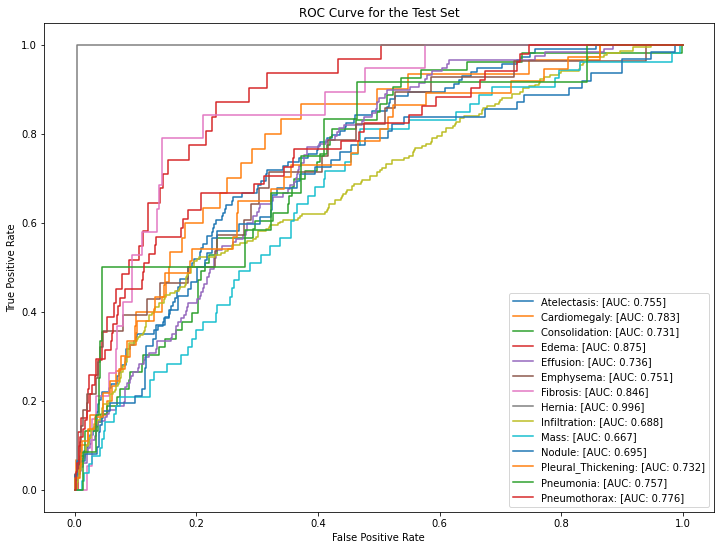

In [ ]:
test_loss, y_preds, y_truth = evaluate_model(testloader, criterion, resnet152)
auc_dict = plot_roc_curve(class_dict, y_preds, y_truth, "Test", get_auc=True)

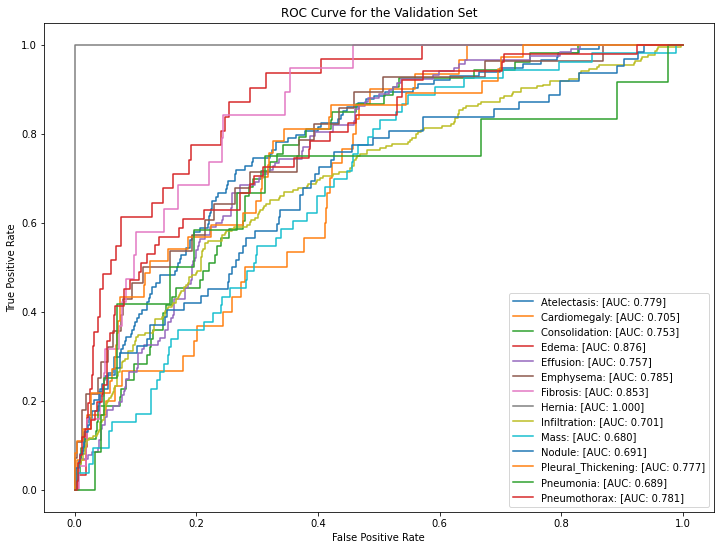

In [ ]:
valid_loss, y_preds, y_truth = evaluate_model(validloader, criterion, resnet152)
auc_dict = plot_roc_curve(class_dict, y_preds, y_truth, "Validation", get_auc=True)

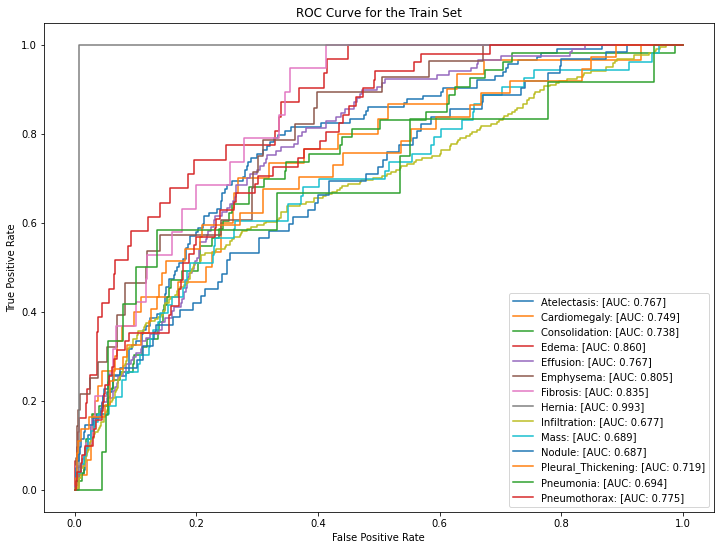

In [ ]:
train_loss, y_preds, y_truth = evaluate_model(trainloader, criterion, resnet152)
auc_dict = plot_roc_curve(class_dict, y_preds, y_truth, "Train", get_auc=True)

# DENSENET 161


In [ ]:
# Re-run
densenet161 = models.densenet161(pretrained = True)

for param in densenet161.parameters():
    param.requires_grad = False

num_in_feats = densenet161.classifier.in_features
densenet161.classifier = nn.Sequential(
            nn.Linear(num_in_feats, 14),
            nn.Sigmoid())
densenet161.classifier


densenet161.to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
lr = 0.001
# optimizer = optim.SGD(densenet121.classifier.parameters(), lr=lr, momentum=0.9, weight_decay=0.1)
optimizer = optim.Adam(densenet161.classifier.parameters(), lr=lr)
factor = 0.1
scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=2, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
epochs = 35
# model_name = "densenet161_adam_e50_bs128_lr00001_reqgrad_test1"
model_name = "densenet161_bce_e30_b16_lr0001_Adam_norm_sched_df_all_images_noNF_labels_random_split"
train_losses, validation_losses = train(epochs, densenet161, trainloader, validloader, criterion, optimizer, scheduler, model_name, valid_loss_min = np.Inf)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Epoch: 1/35, Train Loss: 0.17362, Validation Loss: 0.16960
Decrease in Validation Loss: inf to 0.16960. Saving Model...
Epoch: 2/35, Train Loss: 0.17026, Validation Loss: 0.16893
Decrease in Validation Loss: 0.16960 to 0.16893. Saving Model...
Epoch: 3/35, Train Loss: 0.16972, Validation Loss: 0.16971
Epoch: 4/35, Train Loss: 0.16923, Validation Loss: 0.17698
Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 5/35, Train Loss: 0.16906, Validation Loss: 0.17340
Epoch: 6/35, Train Loss: 0.16193, Validation Loss: 0.16670
Decrease in Validation Loss: 0.16893 to 0.16670. Saving Model...
Epoch: 7/35, Train Loss: 0.16133, Validation Loss: 0.16511
Decrease in Validation Loss: 0.16670 to 0.16511. Saving Model...
Epoch: 8/35, Train Loss: 0.16118, Validation Loss: 0.16509
Decrease in Validation Loss: 0.16511 to 0.16509. Saving Model...
Epoch: 9/35, Train Loss: 0.16136, Validation Loss: 0.16467
Decrease in Validation Loss: 0.16509 to 0.16467. Saving Model...
Epoch: 10/35, Train L

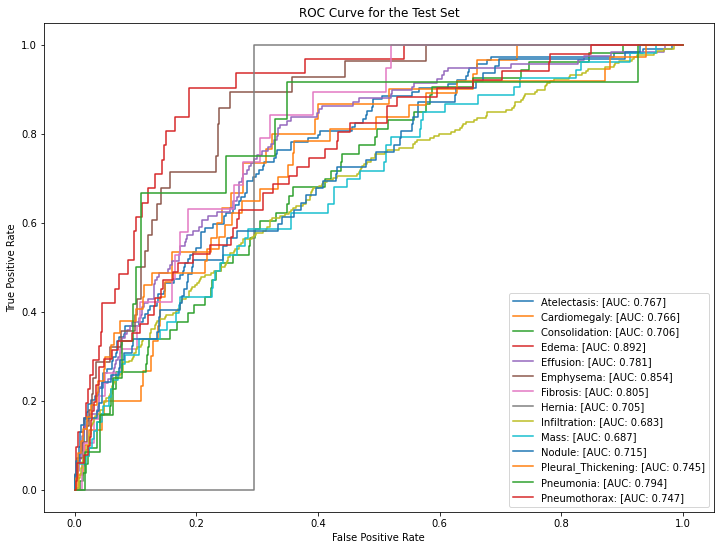

In [ ]:
test_loss, y_preds, y_truth = evaluate_model(testloader, criterion, densenet161)
auc_dict = plot_roc_curve(class_dict, y_preds, y_truth, "Test", get_auc=True)

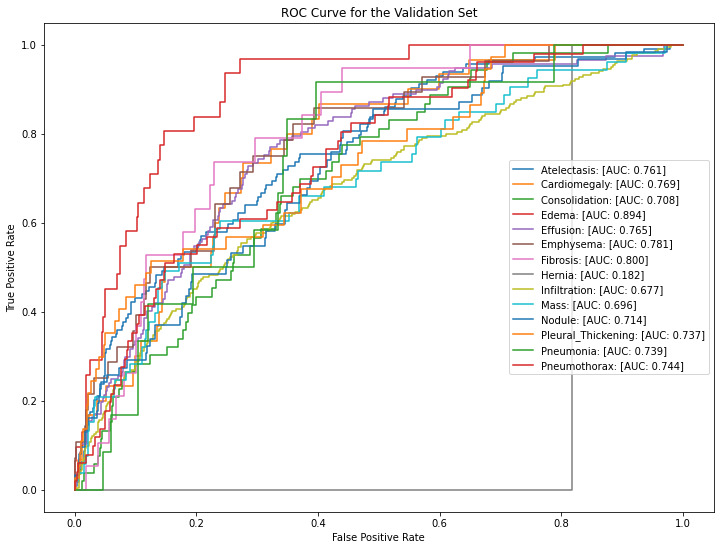

In [ ]:
valid_loss, y_preds, y_truth = evaluate_model(validloader, criterion, densenet161)
auc_dict = plot_roc_curve(class_dict, y_preds, y_truth, "Validation", get_auc=True)

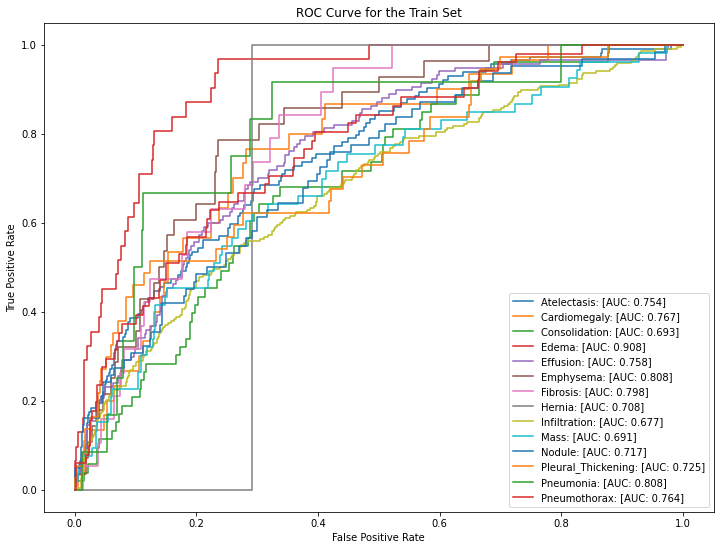

In [ ]:
train_loss, y_preds, y_truth = evaluate_model(trainloader, criterion, densenet161)
auc_dict = plot_roc_curve(class_dict, y_preds, y_truth, "Train", get_auc=True)